# Result analysis

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from experiment import Experiment
from utils import PlaceFields, get_flanks, get_loc_batch, print_stats, eval_position
from agent import Agent
from tqdm import tqdm

In [27]:
exp = Experiment.load_experiment('data', 'het_modular_individual')

In [28]:
exp.compile_grid_cells(1)
exp.load_pfs()

### Fitting losses

Position loss: 0.543


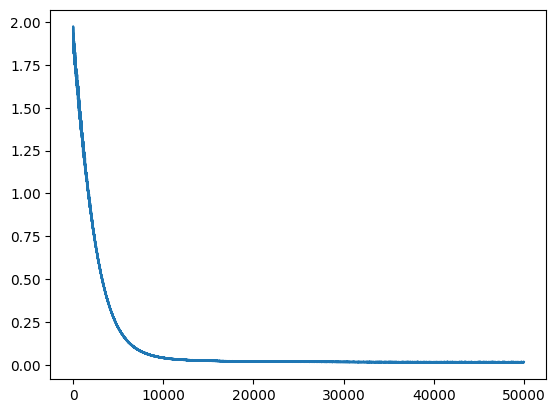

In [29]:
print(f"Position loss: {eval_position(exp.agent, exp.coords, exp.grid_cells):.03f}")
plt.plot(exp.pos_losses)
plt.show()

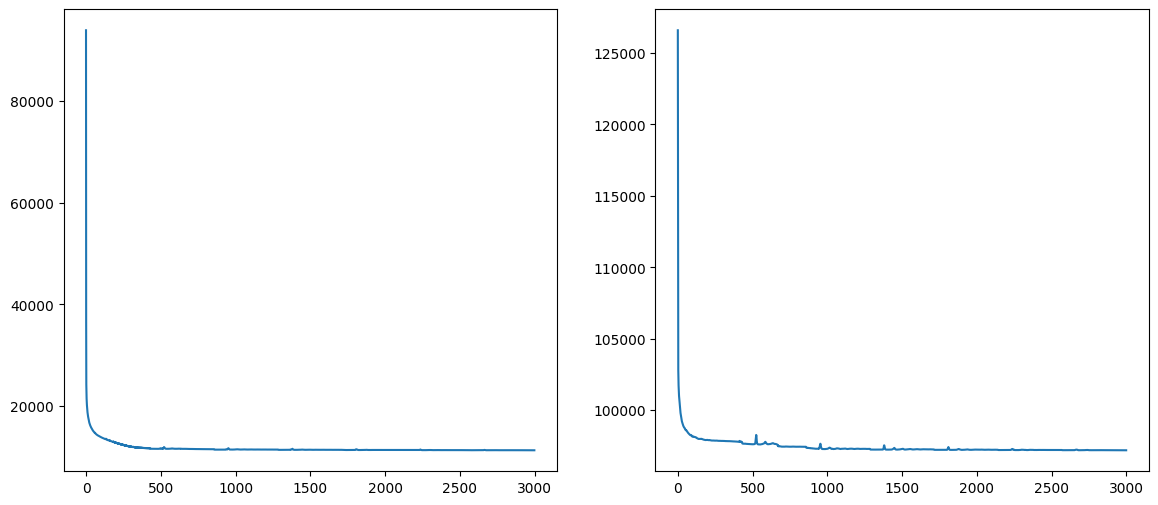

In [30]:
_, axs = plt.subplots(1, len(exp.pfs_losses), figsize=(14, 6))
for ax, loss in zip(axs, exp.pfs_losses.values()):
    ax.plot(loss)
plt.show()

### Network weight analysis

In [31]:
net = exp.agent.actor
net.clamp_weights()

print("Bias stats:")
print_stats(net.b1)
print("\nWeight stats:")
print_stats(net.w1)
print("\nAggregated weight stats:")
print_stats(net.w1.sum(1))

Bias stats:
min   |max  |mean |std  |shape
-0.777|0.534|0.130|0.381|torch.Size([128])

Weight stats:
min   |max  |mean |std  |shape
0.000|2.676|0.063|0.085|torch.Size([128, 1000])

Aggregated weight stats:
min   |max  |mean |std  |shape
53.695|74.564|63.436|7.612|torch.Size([128])


In [32]:
hidden = exp.agent_kwargs['actor_hidden']
idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:].numpy() + [[0], [hidden]]
print(net.lin2.weight[2:].detach().cpu().flatten()[idx.flatten()])

tensor([-4.7417,  5.0029,  5.0564,  5.1586, -5.3465,  4.6387,  5.3242, -5.5602,
        -5.7829,  6.0532])


### Place field analysis

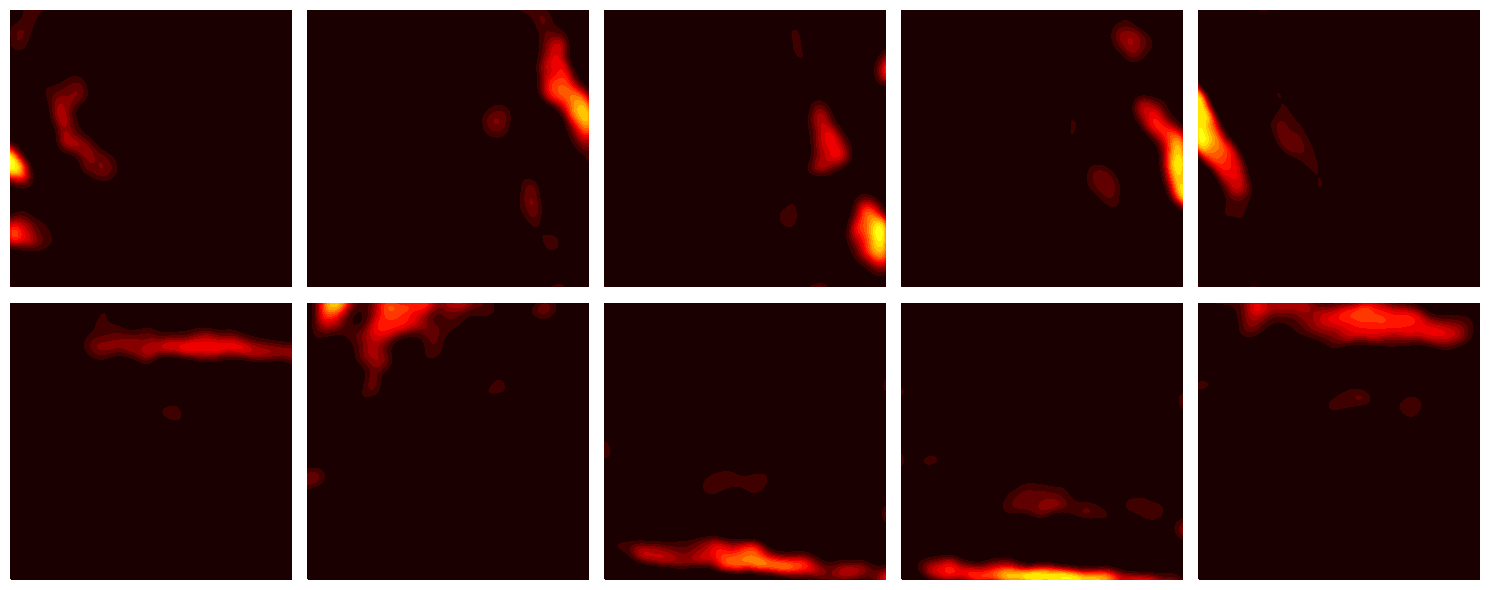

In [33]:
_, axs = plt.subplots(2, 5, figsize=(15, 6))

hidden = net.lin1(exp.grid_cells).permute((-1, 0, 1)).detach().cpu().numpy()

# Small hack to ensure the scale of every plot is the same
hidden[:,0,0] = hidden.max()
hidden[:,0,1] = hidden.min()

idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:]
for img, ax in zip(hidden[idx.flatten()], axs.flatten()):
    ax.contourf(img, levels=20, cmap='hot')
    ax.axis('off')
plt.tight_layout()
plt.show()

Layer 2 weights from most active hidden units
min   |max  |mean |std  |shape
-5.783|6.053|-0.055|3.289|torch.Size([2, 40])

Layer 2 weights from least active hidden units
min   |max  |mean |std  |shape
-2.159|2.770|-0.009|0.350|torch.Size([2, 88])


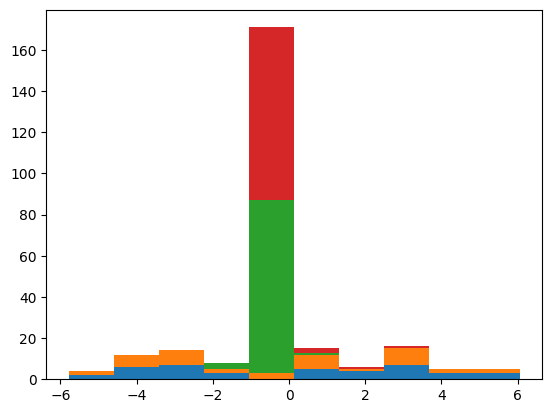

In [34]:
used = hidden.mean((1, 2)) > hidden.mean()# + hidden.mean((1, 2)).std() / 20

print("Layer 2 weights from most active hidden units")
print_stats(net.lin2.weight[2:, used])
print("\nLayer 2 weights from least active hidden units")
print_stats(net.lin2.weight[2:, ~used])

plt.hist([*net.lin2.weight[2:, used].detach().cpu(),
          *net.lin2.weight[2:, ~used].detach().cpu()],
         histtype='barstacked')
plt.show()

In [45]:
exp.compile_grid_cells(1)
exp.load_pfs()

In [46]:
explained1 = 1 - torch.pow(exp.pfs.predict() - exp.pfs.targets, 2).sum((1, 2)) / torch.pow(exp.pfs.targets, 2).sum((1, 2))

In [60]:
explained1

torch.Size([128])

In [83]:
pc1 = set(torch.arange(len(explained1), device=device)[(explained1>0.5)].tolist())
pc2 = set(torch.arange(len(explained), device=device)[(explained>0.5)].tolist())

In [98]:
len(pc2)

11

In [96]:
len(pc1.intersection(pc2)) / len(pc1.union(pc2))

0.25

In [91]:
len(pc1 - pc2) / len(pc1)

0.7241379310344828

In [55]:
(~(explained1 > 0.5)[explained > 0.5])

tensor([False,  True,  True, False, False, False, False, False,  True, False,
        False], device='cuda:0')

In [85]:
(explained1 > 0.5).sum()

tensor(29, device='cuda:0')

In [ ]:
N = exp.pfs.means.shape[0]
preds = exp.pfs.predict().cpu().detach().numpy()
preds[:,0,0] = hidden.max()
hidden[:,0,0] = hidden.max()
explained = 1 - torch.pow(exp.pfs.predict() - exp.pfs.targets, 2).sum((1, 2)) / torch.pow(exp.pfs.targets, 2).sum((1, 2))

for i, (pred, real, expl) in enumerate(zip(preds, hidden[:N], explained.cpu().detach())):
    ax1, ax2 = plt.subplots(1, 2, figsize=(6, 3))[1]
    ax1.contourf(pred, levels=100)
    ax1.axis('off')
    ax1.set_title(f"{expl.item():.04f}")
    ax2.contourf(real, levels=100)
    ax2.axis('off')
    ax2.set_title(i)
    plt.show()

In [36]:
exp.compile_grid_cells(2)
exp.load_pfs()

In [37]:
hidden = net.lin1(exp.grid_cells).permute((-1, 0, 1)).detach().cpu().numpy()
hidden[:,0,0] = hidden.max()
hidden[:,0,1] = hidden.min()

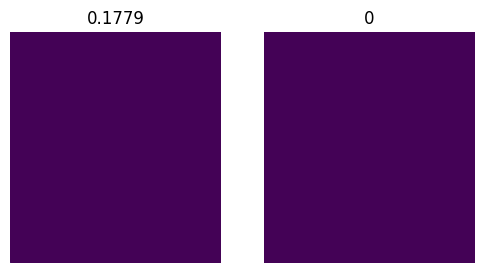

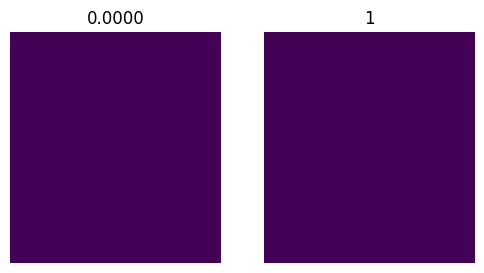

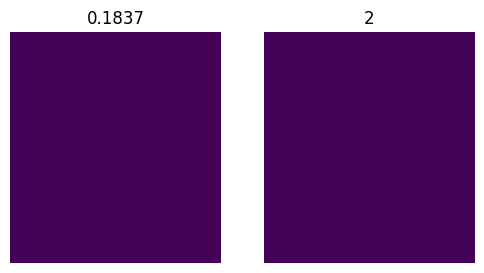

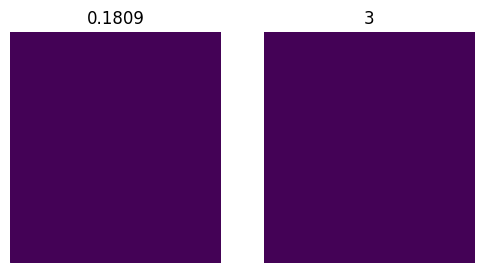

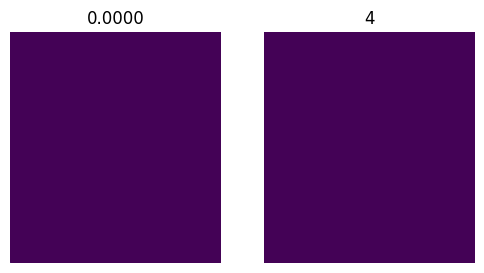

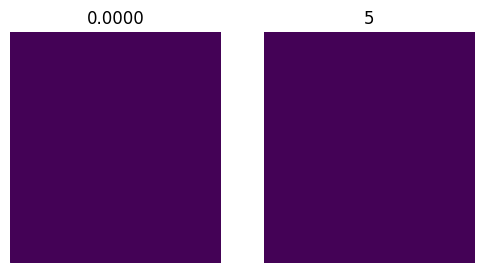

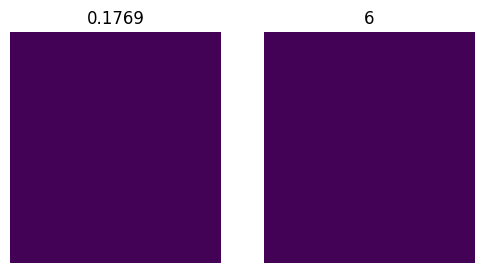

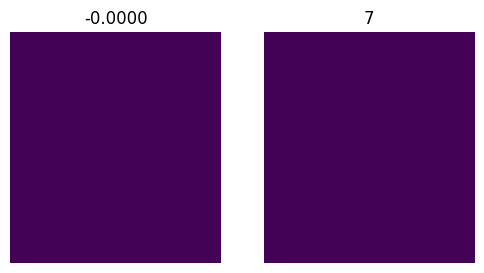

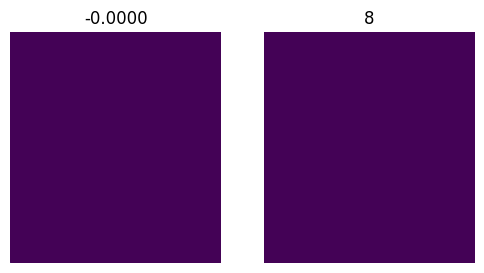

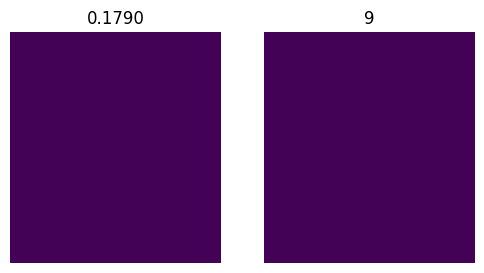

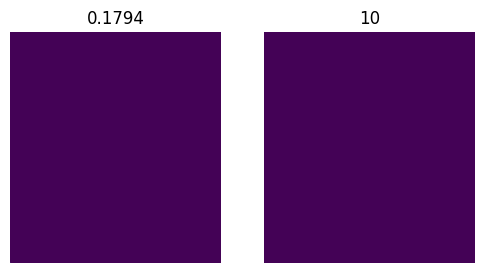

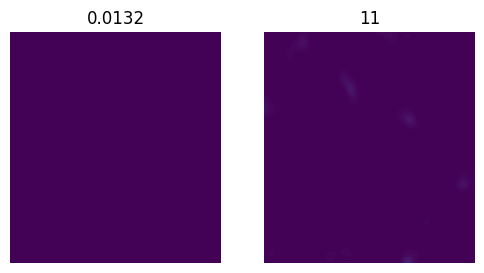

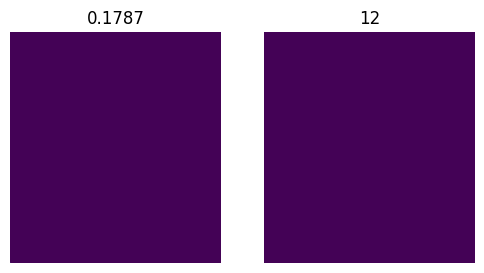

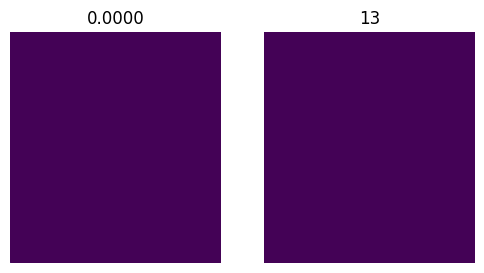

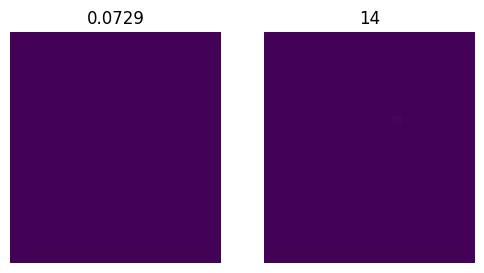

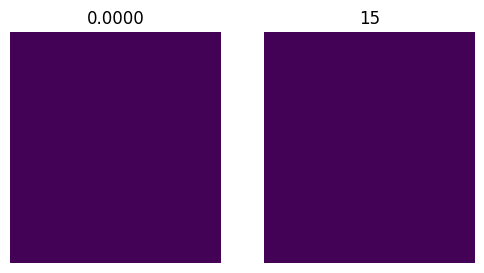

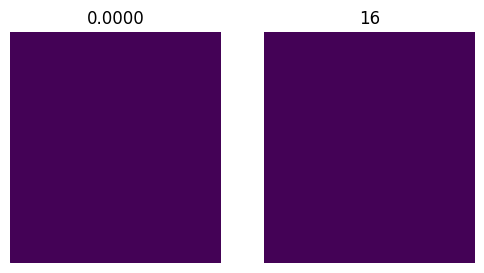

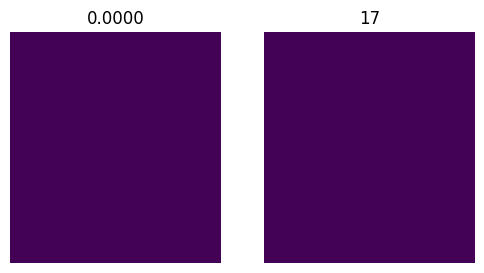

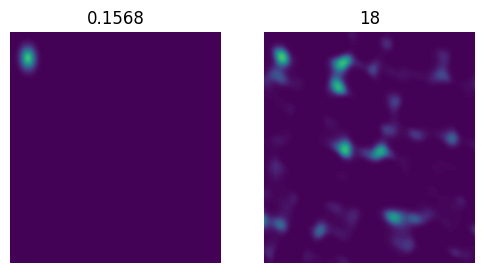

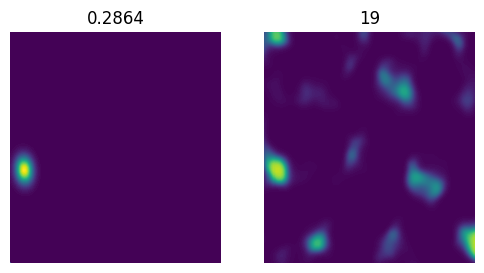

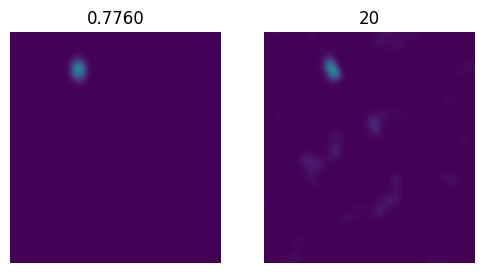

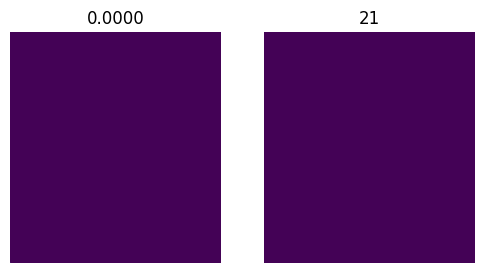

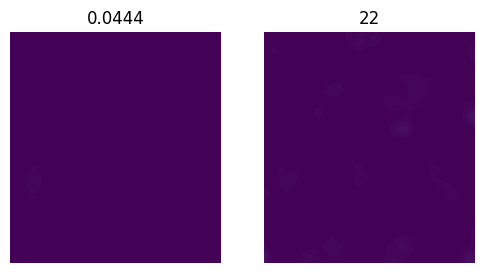

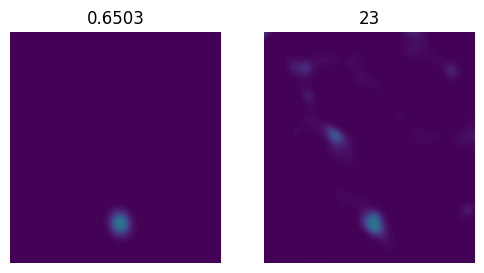

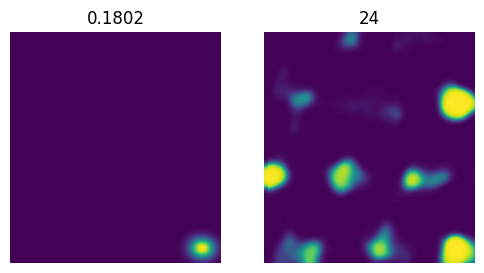

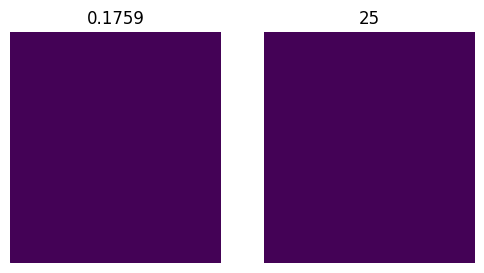

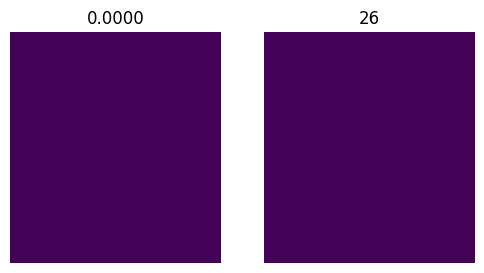

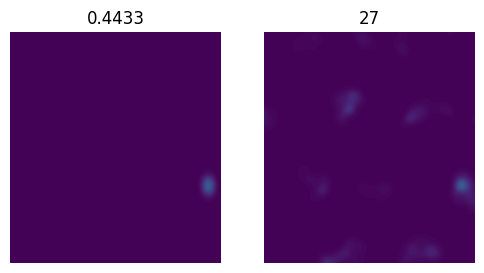

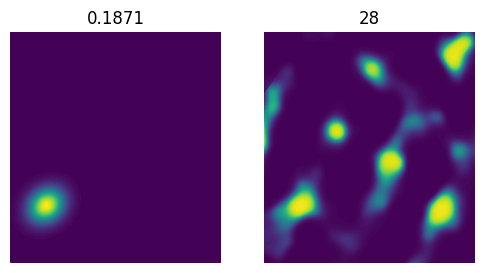

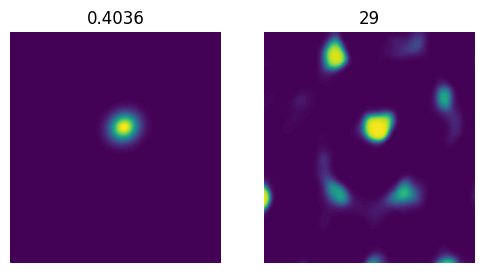

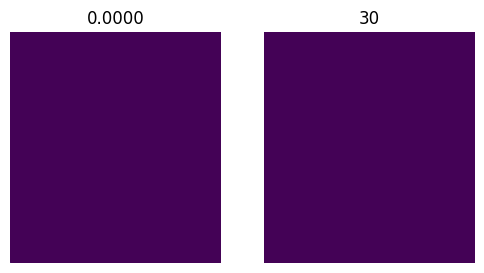

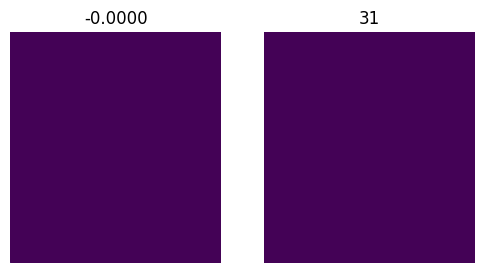

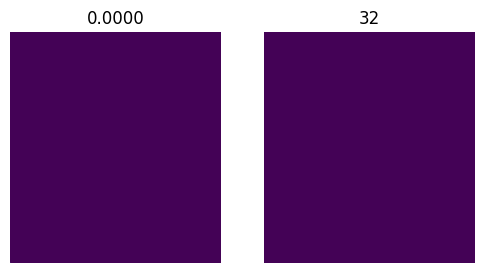

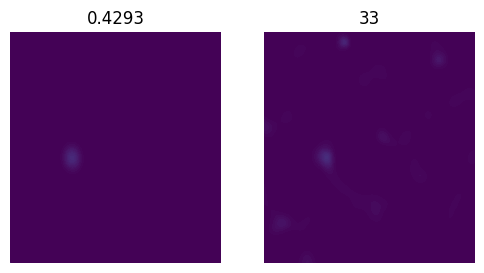

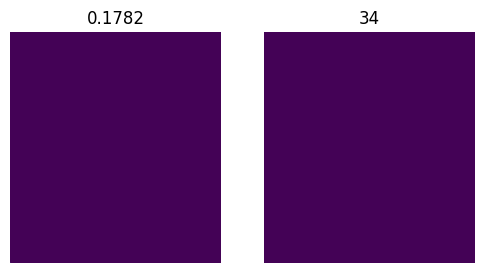

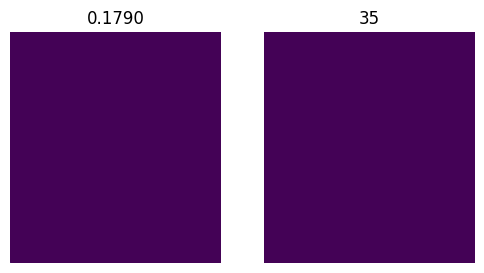

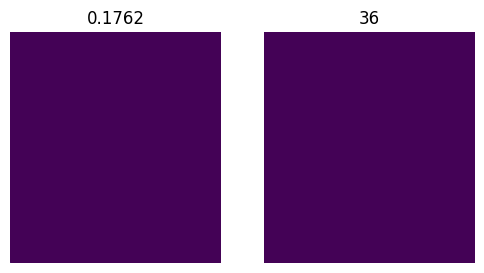

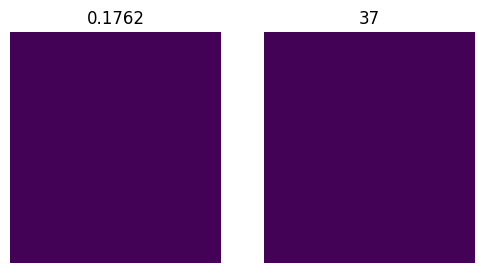

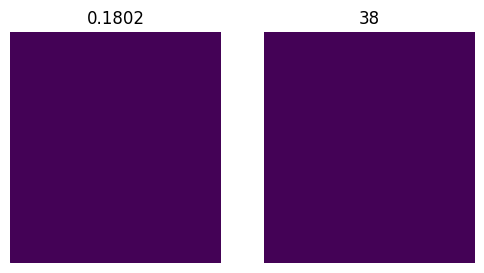

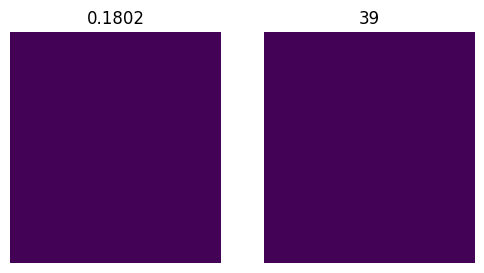

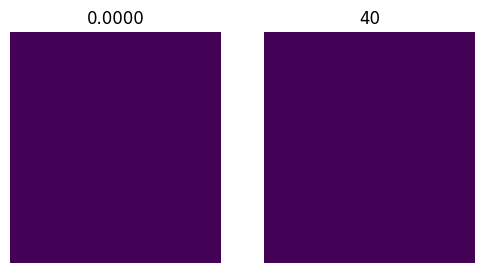

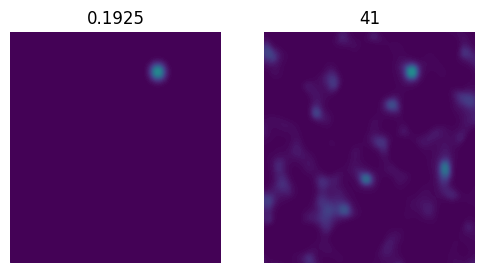

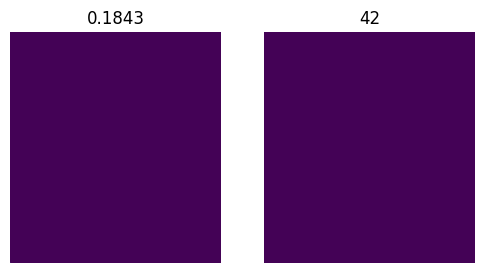

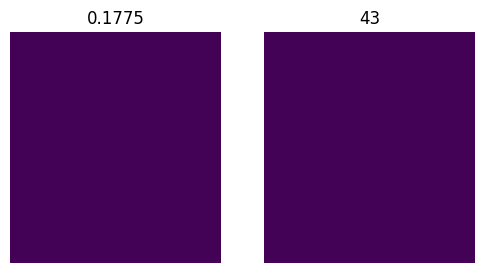

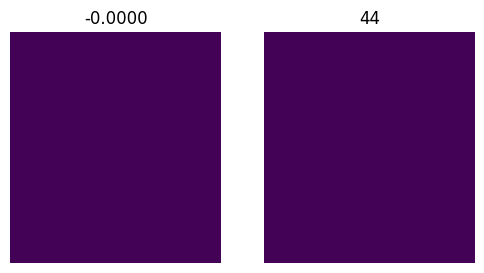

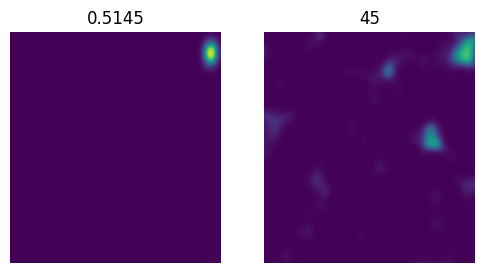

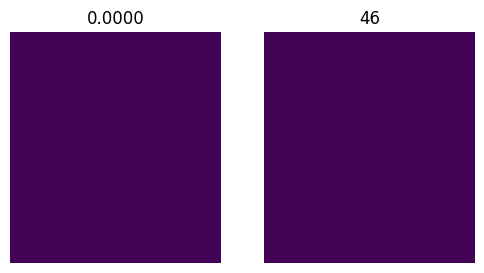

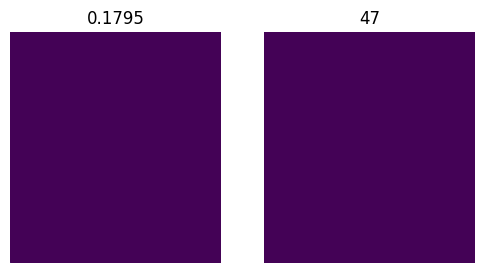

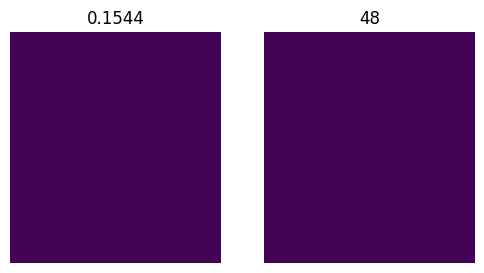

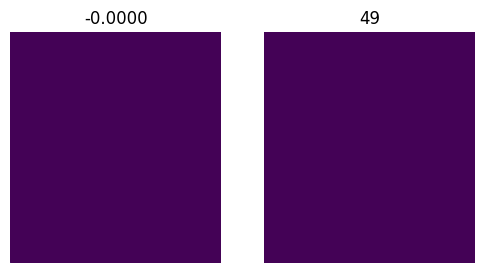

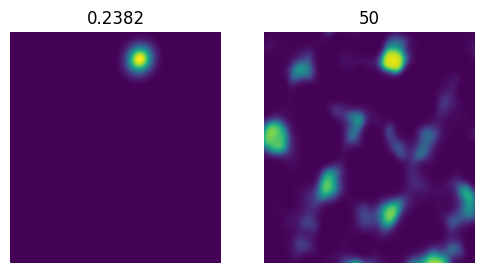

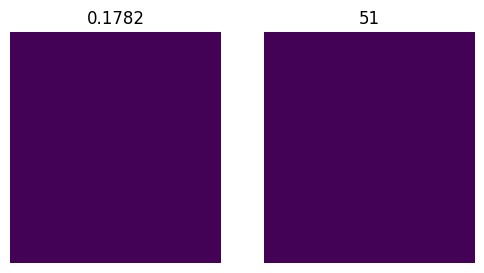

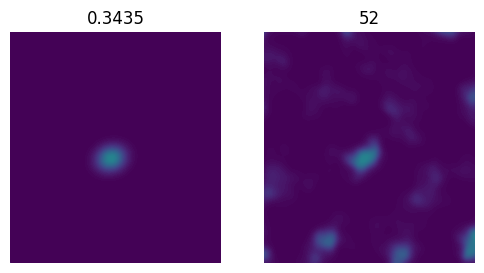

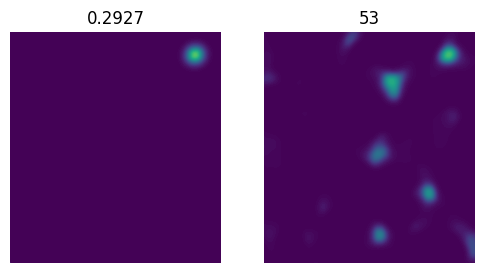

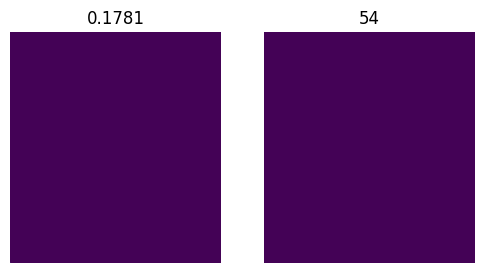

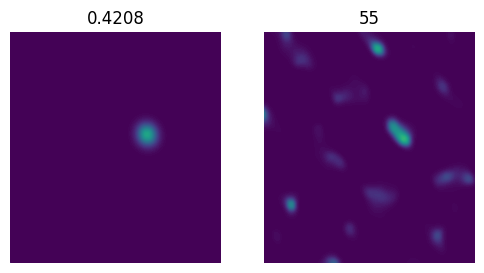

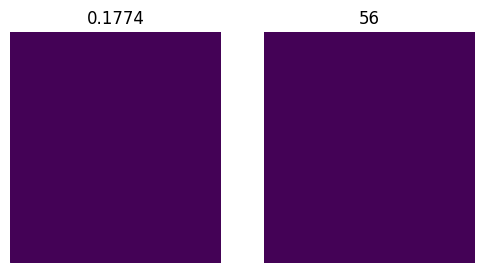

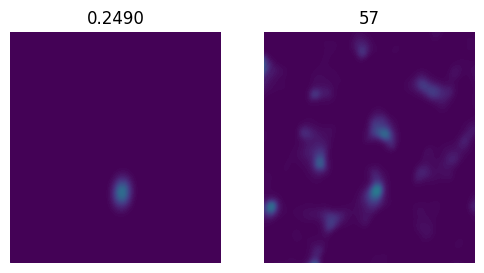

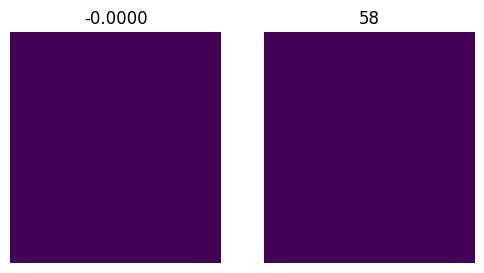

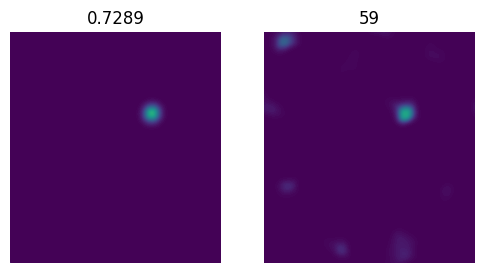

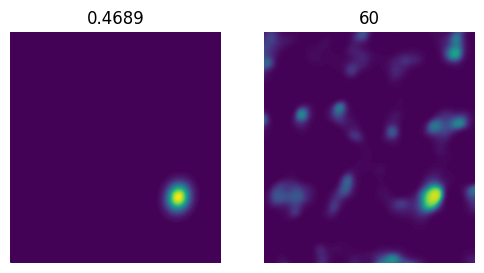

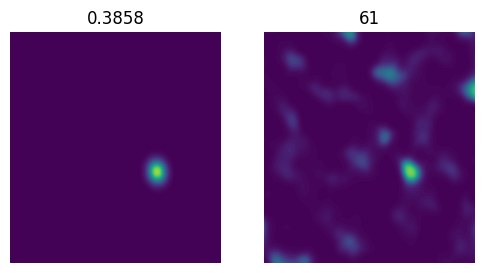

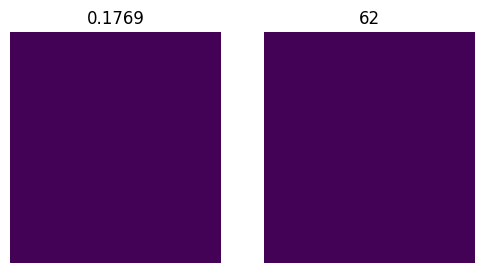

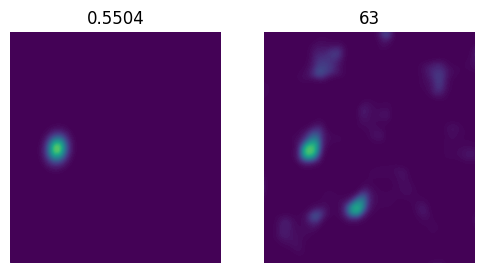

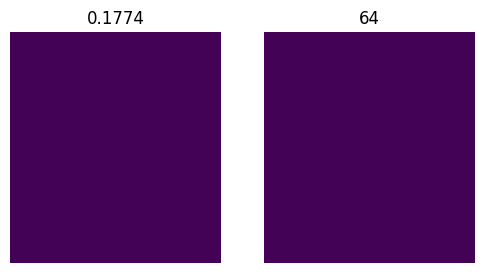

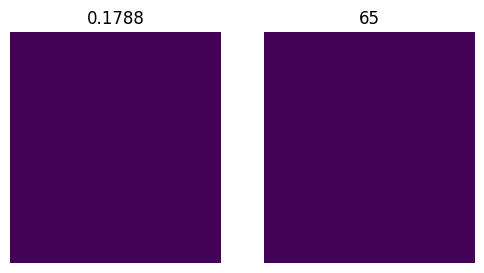

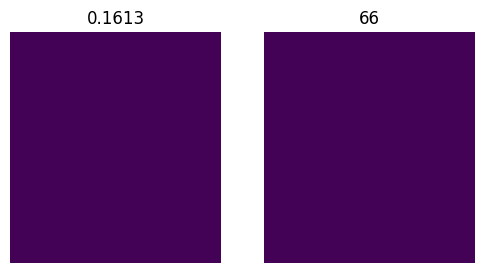

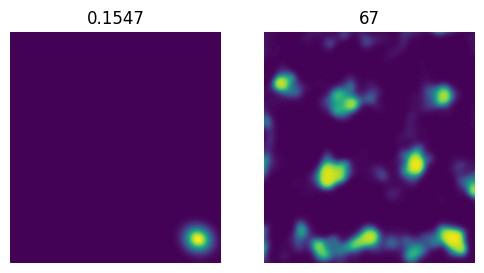

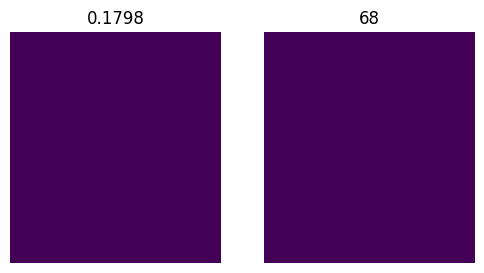

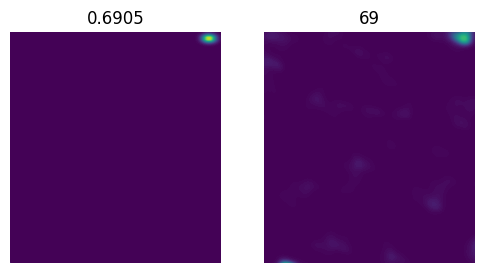

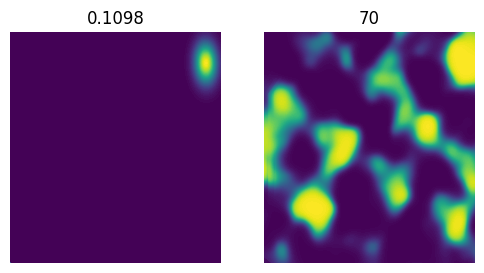

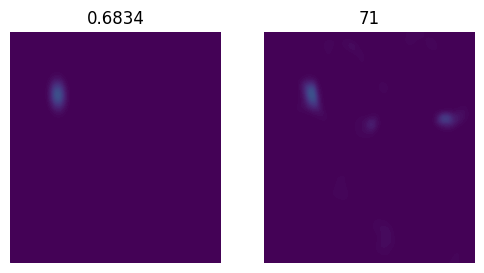

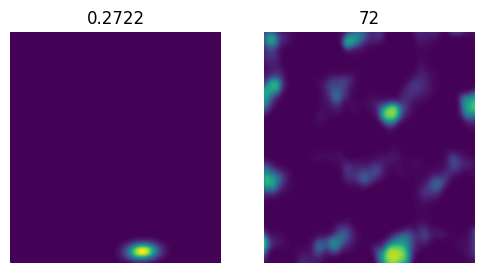

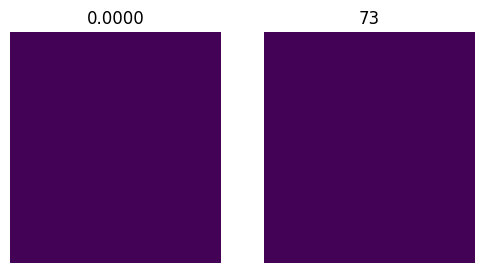

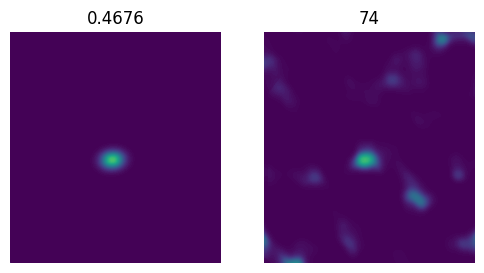

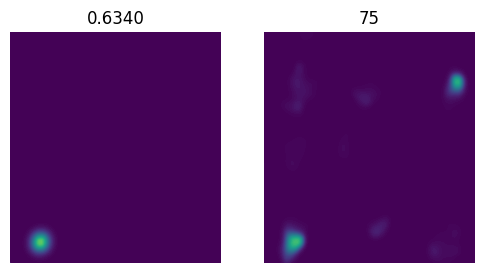

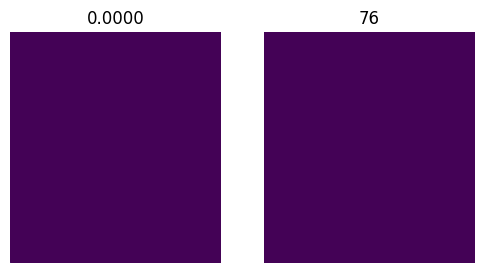

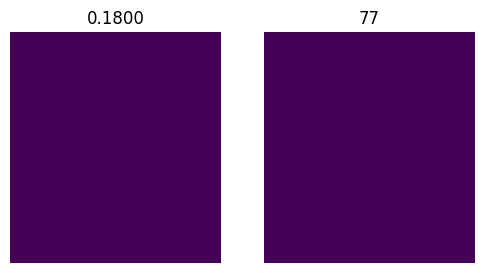

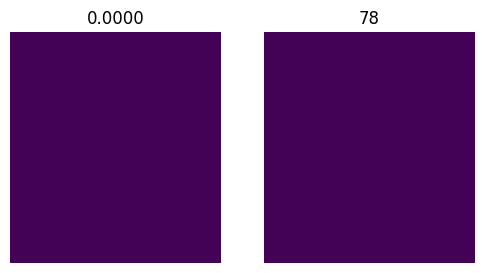

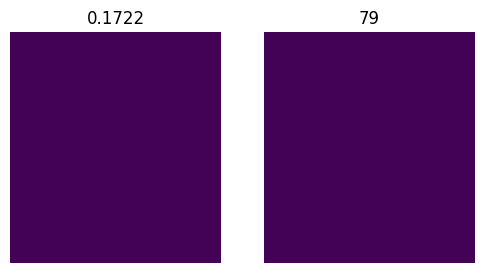

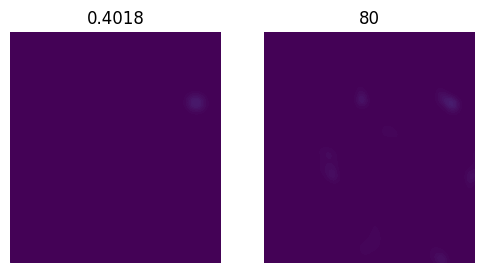

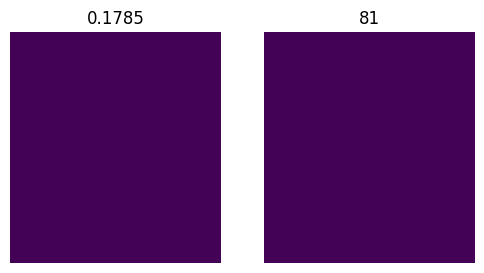

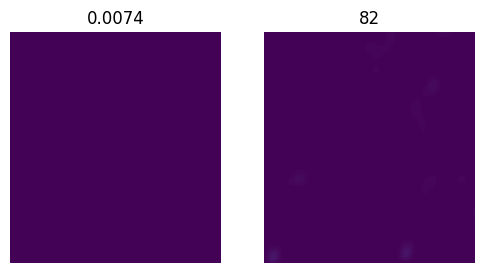

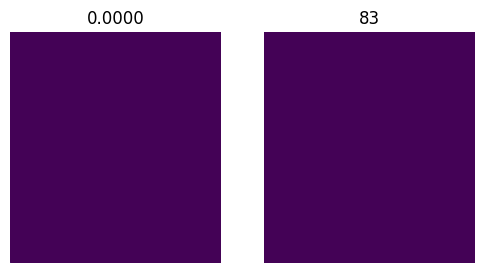

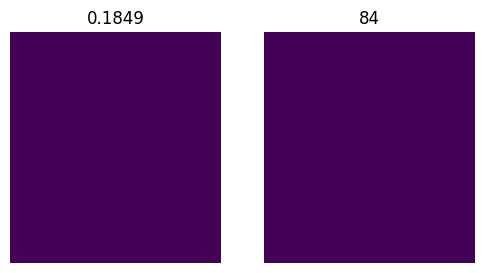

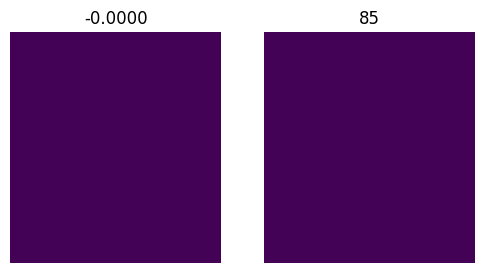

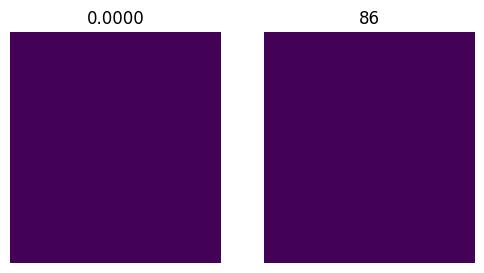

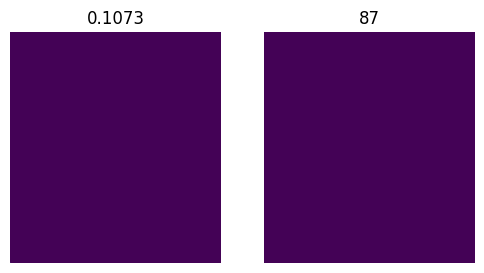

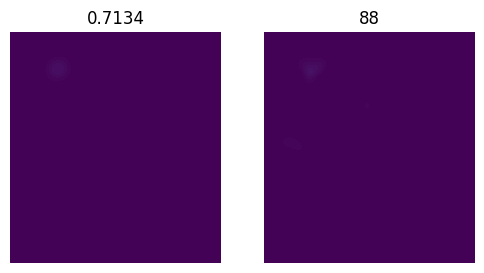

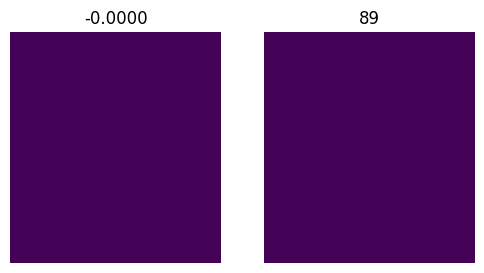

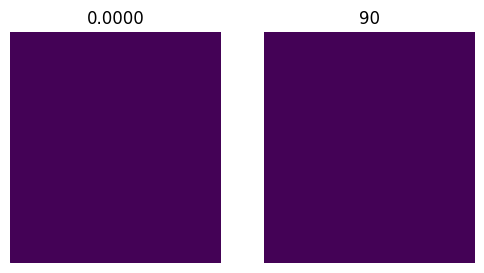

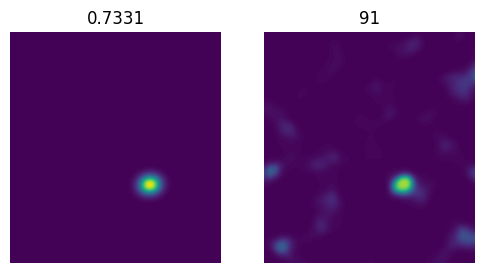

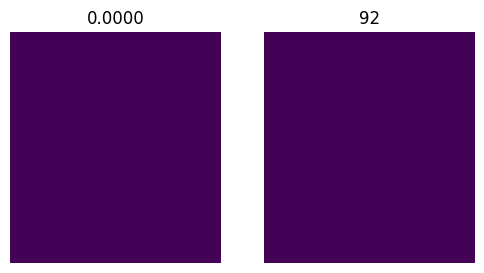

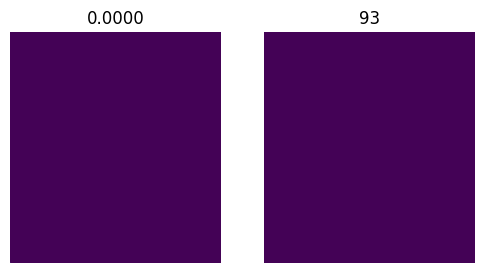

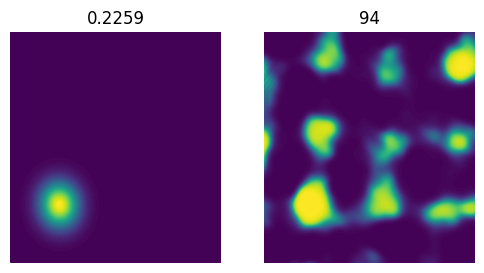

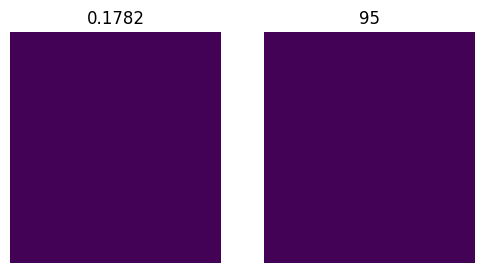

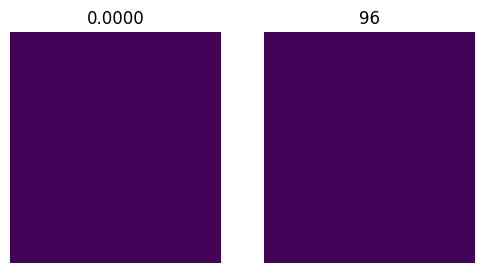

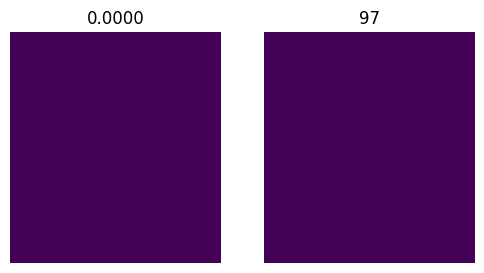

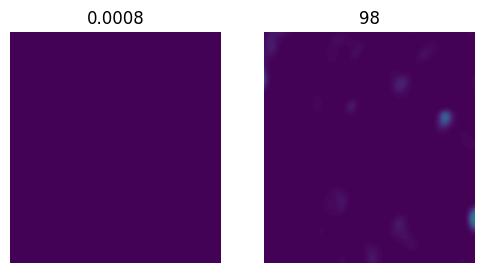

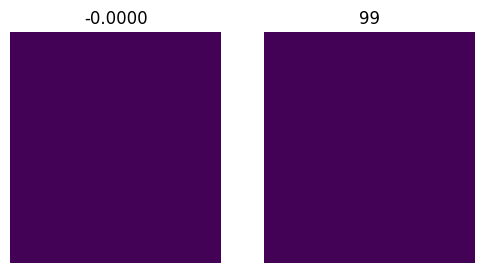

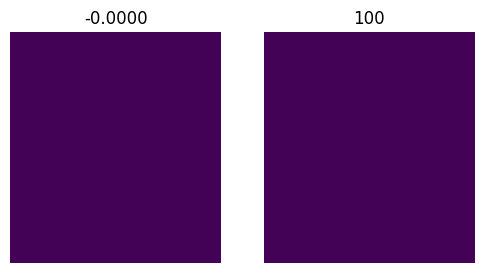

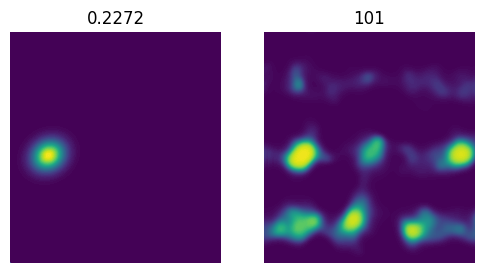

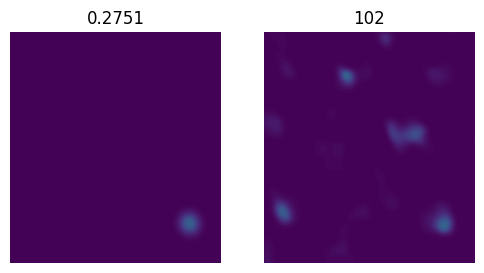

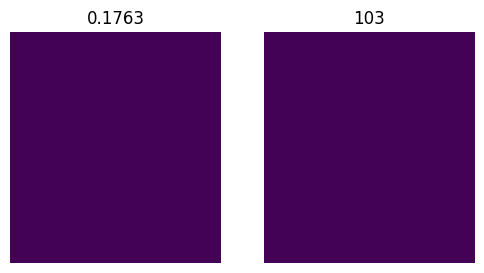

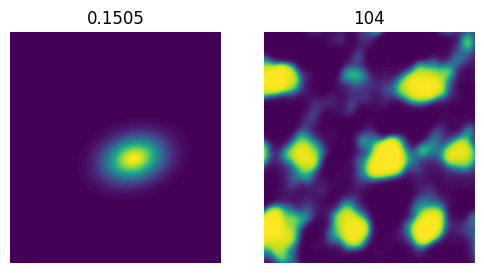

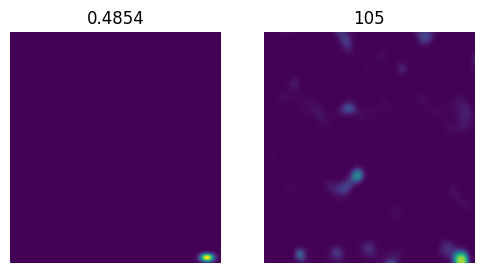

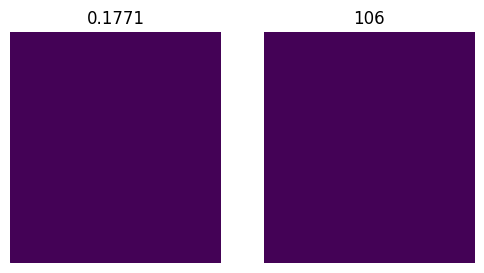

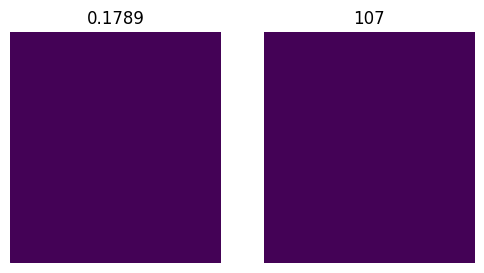

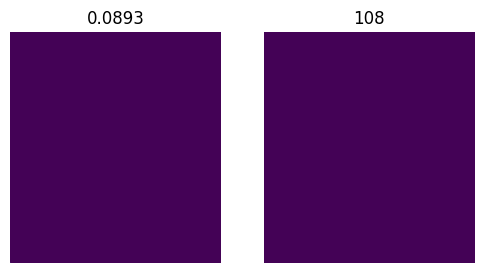

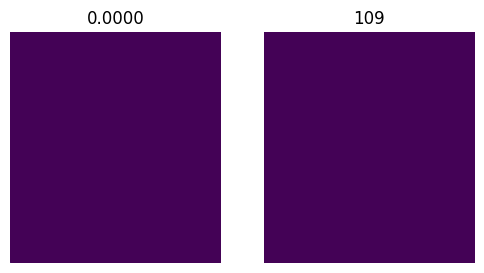

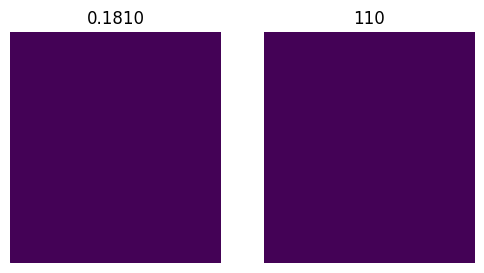

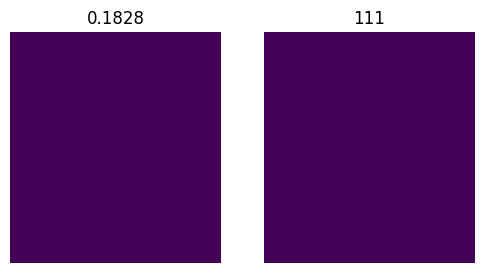

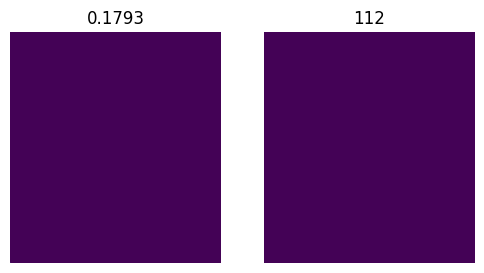

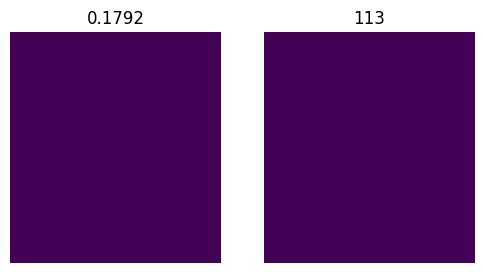

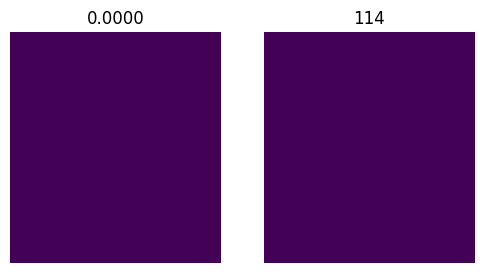

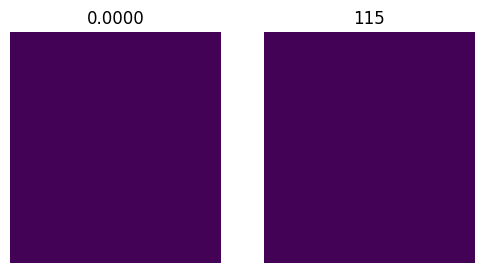

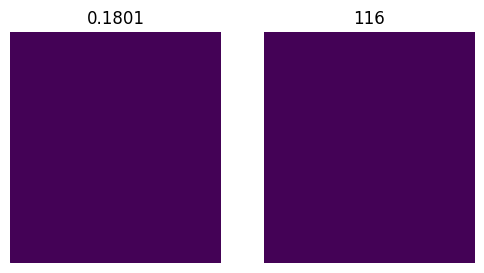

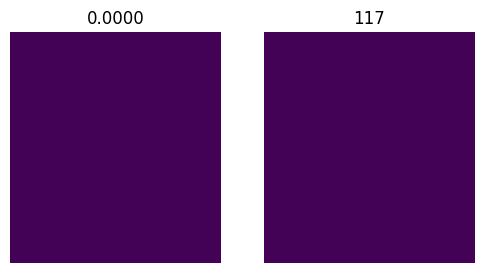

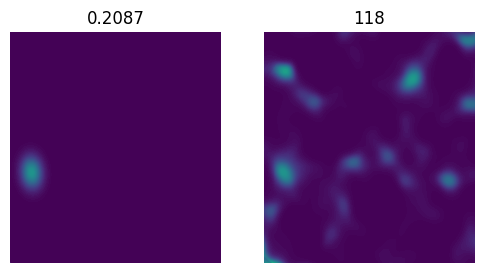

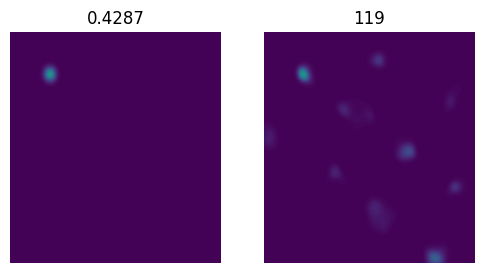

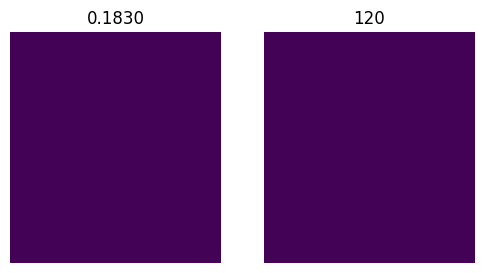

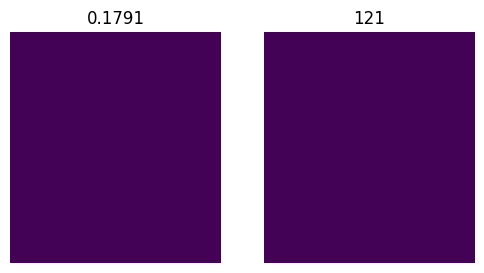

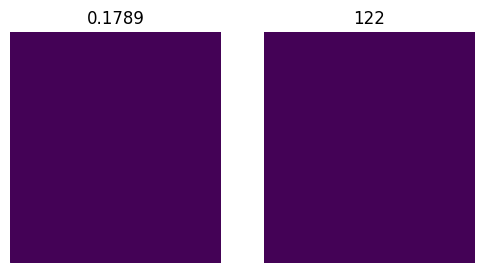

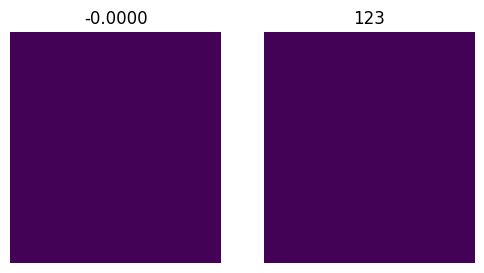

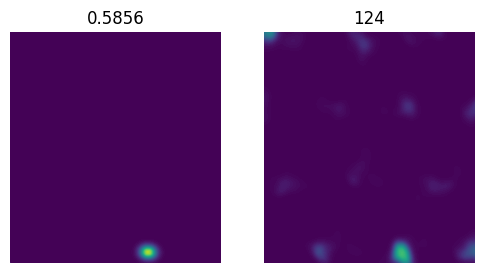

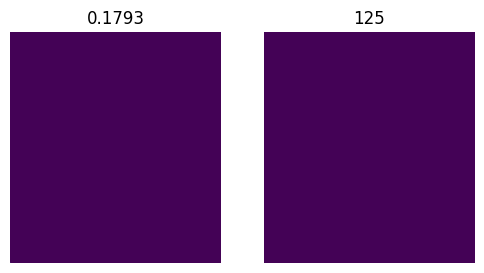

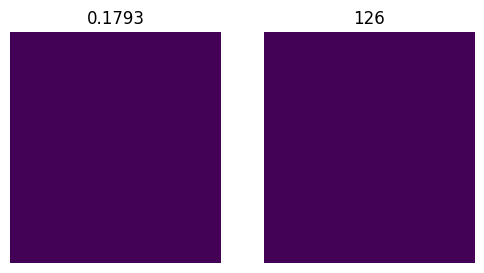

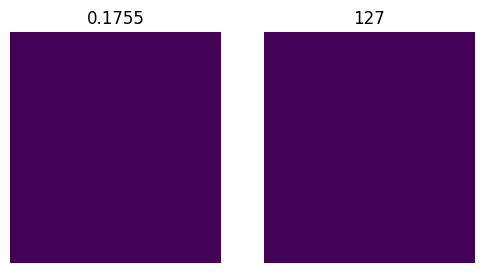

In [38]:
N = exp.pfs.means.shape[0]
preds = exp.pfs.predict().cpu().detach().numpy()
preds[:,0,0] = hidden.max()
hidden[:,0,0] = hidden.max()
explained = 1 - torch.pow(exp.pfs.predict() - exp.pfs.targets, 2).sum((1, 2)) / torch.pow(exp.pfs.targets, 2).sum((1, 2))

for i, (pred, real, expl) in enumerate(zip(preds, hidden[:N], explained.cpu().detach())):
    ax1, ax2 = plt.subplots(1, 2, figsize=(6, 3))[1]
    ax1.contourf(pred, levels=100)
    ax1.axis('off')
    ax1.set_title(f"{expl.item():.04f}")
    ax2.contourf(real, levels=100)
    ax2.axis('off')
    ax2.set_title(i)
    plt.show()